# Lab 2: Regression with Dummy Variables

In this lab, we will run regressions with dummy variables (also known as binary variables or indicator variables). 

🎯 In this script, you will learn how to:

- Load data from a local CSV file
- Create dummy variables from a numeric variable
- Run a regression with dummy variables
- Interpret the regression results
- Conduct an ANOVA test
  - to compare means across groups
  - to compare models

## Instructions

Copy and paste **ALL code** in this page into a new R script file in RStudio. Save the file as `lab2_binary_variables.R` (we call it a script or a source file). Then, run the code step by step, answering the questions.

Alternatively, use [Google Colab](https://colab.research.google.com/drive/1EcWkJfhHJOhDEHXaZgu3_f66pnlEum5R?usp=share_link).

In [1]:
# load packages and dataset
pkgs <- c("tidyverse", "moments", "data.table", "stargazer")
missing <- setdiff(pkgs, rownames(installed.packages()))
if (length(missing) > 0) install.packages(missing)
invisible(lapply(pkgs, function(pkg) suppressPackageStartupMessages(library(pkg, character.only = TRUE))))

## Load data into working directory

We continue to use the same dataset California school dataset (CASchools). Refer to [Data Visualization: Dataset Overview](02_Data_Visualization.qmd#dataset-overview) for detailed description of the dataset.

Previously, we loaded the data directly from an online data repository. Now, we will load the data from a local CSV file. 

Download the `CASchools_test_score.csv` file from Canvas and placed it in the same folder as where you put `lab2_binary_variables.R`. This is to make sure that the script can find the data file.

- Depending on your computer setting, you may or may not see the file extension `.csv`. 
- You can rename the data file, note that the data file name needs to match the `f_name` used in the code below.


Troubleshooting: If you get an error message like 

> Error: 'CASchools_test_score.csv' does not exist in current working directory ('path-to-file').

It means that your working directory is not set to the folder where you put the data file. You need to set your working directory to that folder. You can do this in RStudio by clicking on `Session` -> `Set Working Directory` -> `Set to Source File Location`. Then, run the code again.

<img src="https://drive.google.com/thumbnail?id=1SUWZqcQhGjE2t_MDzqrkR15sX5CDKnWi&sz=w1000" alt="" style="display: block; margin-right: auto; margin-left: auto; zoom:80%;" />

In [2]:
# load dataset
f_name <- "CASchools_test_score.csv"
cas <- read_csv(f_name)
# data preview, first and last 5 rows
cas %>% as.data.table() %>% print(topn = 5)

     district                          school      county grades students
        <num>                          <char>      <char> <char>    <num>
  1:    75119              Sunol Glen Unified     Alameda  KK-08      195
  2:    61499            Manzanita Elementary       Butte  KK-08      240
  3:    61549     Thermalito Union Elementary       Butte  KK-08     1550
  4:    61457 Golden Feather Union Elementary       Butte  KK-08      243
  5:    61523        Palermo Union Elementary       Butte  KK-08     1335
 ---                                                                     
416:    68957          Las Lomitas Elementary   San Mateo  KK-08      984
417:    69518            Los Altos Elementary Santa Clara  KK-08     3724
418:    72611          Somis Union Elementary     Ventura  KK-08      441
419:    72744               Plumas Elementary        Yuba  KK-08      101
420:    72751            Wheatland Elementary        Yuba  KK-08     1778
     teachers calworks   lunch compute

Prepare dataset for analysis. 

As done previously, we create the following variables:

- `TestScore`: average test score of students in a school (average of math and reading scores)
- `str`: student-teacher ratio

In [3]:
cas <- cas %>%
    mutate(
        TestScore = (read + math) / 2,
        STR = students / teachers
    )

## Regression When $X$ is a Binary Variable

Instead of using a continuous regressor $X$ , we might be interested in running the regression

$$
Y_i = \beta_0 + \beta_1 D_i + u_i, 
$$ {#eq-binary-regression}

where $D_i$ is a binary variable, a so-called dummary variable. For example, we may defined $D_i$ as follows:

$$
D_i = 
\begin{cases}
    1 & \text{if $STR$ in $i^{th}$ school district < 20} \\
    0 & \text{if $STR$ in $i^{th}$ school district $\geq$ 20}.
\end{cases}
$$ {#eq-dummy-variable}

The regression model now is 

$$
TestScore_i = \beta_0 + \beta_1 D_i + u_i.
$$

### Data Visualization

In [4]:
# Create the dummy variable as defined above
# D=1 (low STR); D=0 (high STR)
cas$D <- cas$STR < 20


In [5]:
# Compute group means
means <- aggregate(TestScore ~ D, data = cas, mean)
means

D,TestScore
<lgl>,<dbl>
FALSE,650.0768
TRUE,657.2462


In [6]:
#| echo: false
p <- ggplot(cas, aes(x = factor(D), y = TestScore)) +
    # scatter points, spreads the points horizontally so they don't overlap
    geom_jitter(width = 0.1, height = 0, size = 0.5, color = "steelblue") +
    geom_point(
        data = means, aes(x = factor(D), y = TestScore),
        color = "red", size = 2
    ) + # group means
    labs(
        x = expression(D[i]),
        y = "Test Score",
    ) +
    theme_minimal(base_size = 14)
f_name <- "images/dummy_plot.png"
ggsave(f_name, p, width = 6, height = 4, dpi = 300, units = "in")

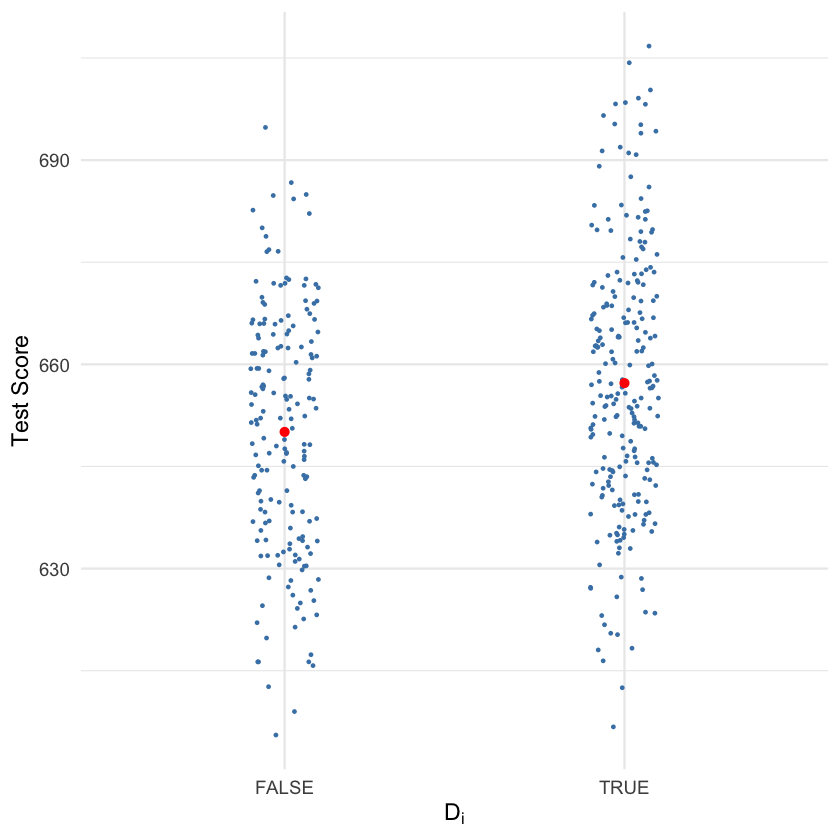

In [ ]:
#| eval: false
#| output: false
ggplot(cas, aes(x = factor(D), y = TestScore)) +
    # scatter points, spreads the points horizontally so they don't overlap
    geom_jitter(width = 0.1, height = 0, size = 0.5, color = "steelblue") +
    geom_point(
        data = means, aes(x = factor(D), y = TestScore),
        color = "red", size = 2
    ) + # group means
    labs(
        x = expression(D[i]),
        y = "Test Score",
    ) +
    theme_minimal(base_size = 14)

In [8]:
#| echo: false
# Display the image with controlled width and centered
library(IRdisplay)
display_html(paste0('<div style="text-align: center;"><img src="', f_name, '" style="width: 70%; height: auto;"></div>'))

We see that small size class has higher average test score.

### Regression with a Binary Variable

With $D$ as the regressor, it is not useful to think of $\beta_1$ as a slope parameter since since $D_i \in \{0,1\},$ i.e., we only observe two discrete values instead of a continuum of regressor values. There is no continuous line depicting the conditional expectation function $E(TestScore_i | D_i)$ since this function is solely defined for $x$-positions $D_i = 0$ and $D_i = 1$.

Therefore, <span class="env-green">**the interpretation**</span> of the coefficients in this regression model is as follows:

- $E(Y_i | D_i = 0) = \beta_0$, so $\beta_0$ is the expected test score in districts where $D_i = 0$ and $STR$ is larger or equal to 20.
- $E(Y_i | D_i = 1) = \beta_0 + \beta_1$, or $\beta_1 = E(Y_i | D_i = 1) - E(Y_i | D_i = 0).$ Thus, $\beta_1$ is the difference in group-specific expectations, i.e., the difference in expected test score between districts with $STR<20$ and those with $STR \geq 20.$

We now estimate the dummary regression model as defined by Equations (-@eq-binary-regression) and (-@eq-dummy-variable).

In [9]:
dummy_model_slr <- lm(TestScore ~ D, data = cas)
stargazer(dummy_model_slr, type = "text", title = "Dummy Variable Regression Results", digits = 3)


Dummy Variable Regression Results
                        Dependent variable:    
                    ---------------------------
                             TestScore         
-----------------------------------------------
D                            7.169***          
                              (1.847)          
                                               
Constant                    650.077***         
                              (1.393)          
                                               
-----------------------------------------------
Observations                    420            
R2                             0.035           
Adjusted R2                    0.032           
Residual Std. Error      18.741 (df = 418)     
F Statistic           15.073*** (df = 1; 418)  
Note:               *p<0.1; **p<0.05; ***p<0.01


💡 Q: **Based on the regression output, answer the following questions:**

- What is the average test score in school districts with $STR \geq 20$?
- What is the average test score in school districts with $STR < 20$?
- What is the difference in average test score between school districts with $STR < 20$ and those with $STR \geq 20$?
- Is the difference statistically significant at the 5% significance level?

## MLR with a Binary Variable

In [10]:
dummy_model_mlr <- lm(TestScore ~ computer + english + lunch + D, data = cas)
stargazer(dummy_model_slr, dummy_model_mlr,
    type = "text",
    title = "Regression Results",
    column.labels = c("SLR", "MLR"),
    digits = 3
)


Regression Results
                                  Dependent variable:               
                    ------------------------------------------------
                                       TestScore                    
                              SLR                     MLR           
                              (1)                     (2)           
--------------------------------------------------------------------
computer                                             0.001          
                                                    (0.001)         
                                                                    
english                                            -0.139***        
                                                    (0.034)         
                                                                    
lunch                                              -0.544***        
                                                    (0.022)         
              

💡 Q: **Comparing the regression results of the simple regression with a binary variable and the multiple regression with additional control variables, answer the following questions:**

- How does the coefficient of the binary variable change when we add more control variables?
- Why does the estimated effect of small classes shrink when other control variables are included?
- Does the smaller coefficient in the multiple linear regression model mean small classes are unimportant, or does it mean we now have a less biased estimate of their effect? Explain.

## ANOVA test

### One-way ANOVA test

The purpose of a one-way ANOVA (analysis of variance) test is to determine the existence of a statistically significant difference among the means of three or more populations. The test actually uses variances to help determine if the population means are equal or not.

In what follows, we will use the one-way ANONA test to examine whether the average test scores differ across schools with different sizes of student-teacher ratios (STR).

We first **create a new categorical variable** `str_cat` based on the variable `str` (student-teacher ratio):

- Small size class: STR < 18
- Medium size class: 18 ≤ STR < 21
- Large size class: STR ≥ 21

Then, we run the one-way ANOVA test to see if the average test scores differ across schools with different sizes of student-teacher ratios (STR).

Null and alternative hypotheses:

- $H_0$: The average test scores are the same across schools with different sizes of student-teacher ratios (STR).
- $H_1$: At least one pair of average test scores are different.

In [11]:
cas <- cas %>%
    mutate(
        str_cat = case_when(
            STR < 18 ~ "Small",
            STR >= 18 & STR < 21 ~ "Medium",
            STR >= 21 ~ "Large"
        )
    )
cas$str_cat %>% table()

.
 Large Medium  Small 
    92    253     75 

In [12]:
# ANOVA test
anova_result <- aov(TestScore ~ str_cat, data = cas)
summary(anova_result)

             Df Sum Sq Mean Sq F value   Pr(>F)    
str_cat       2   9101    4551   13.27 2.59e-06 ***
Residuals   417 143008     343                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Given the significance level $\alpha = 0.05$, we reject the null hypothesis (p-value < 0.05) and conclude that at least one pair of average test scores are different across schools with different sizes of student-teacher ratios (STR).

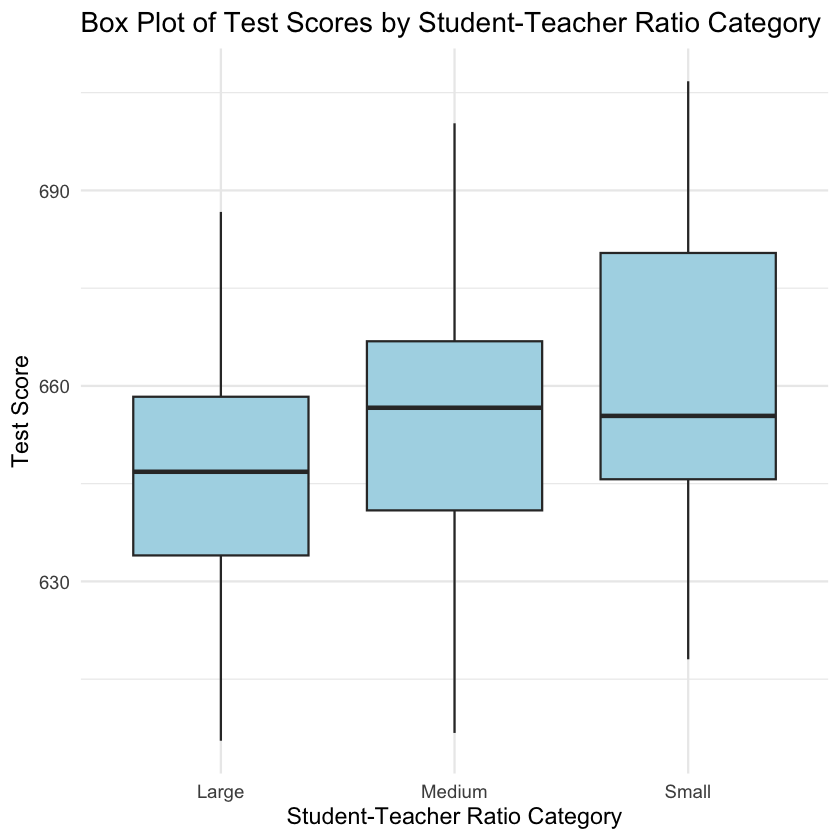

In [13]:
# Box plot of TestScore by str_cat
p_anova <- ggplot(cas, aes(x = str_cat, y = TestScore)) +
    geom_boxplot(fill = "lightblue") +
    labs(
        x = "Student-Teacher Ratio Category",
        y = "Test Score",
        title = "Box Plot of Test Scores by Student-Teacher Ratio Category"
    ) +
    theme_minimal(base_size = 14)
p_anova

### Two-way ANOVA test

The two-way ANOVA test is used to compare the fits of two regression models.

- Test for Improvement: It tests whether adding more predictors (variables) to a model significantly improves the model’s ability to explain the variability in the response variable.

- Model Selection: Helps in deciding between a simpler model with fewer variables and a more complex one with more variables.

For instance, consider we have two models:

- Model 1: $y = \beta_0 + \beta_1 x_{1} + \varepsilon$, and
- Model 2: $y = \beta_0 + \beta_1 x_{1} + \beta_2 x_2 + \beta_3 x_3 + \varepsilon$.

We can form a test by comparing the $R^2$ from the two models.

$$
\begin{aligned}
&\text{H}_0: \beta_2 = \beta_3 = 0 \\
&\text{H}_1: \beta_2 \ne 0 \text{ or } \beta_3\ne 0 ,
\end{aligned}
$$
which imposes two exclusion restrictions.

Coming back to our California school TestScore example, we can use the two-way ANOVA test to see if the multiple regression model with additional control variables (Model 2) significantly improves the model’s ability to explain the variability in TestScore compared to the simple regression model (Model 1).

In [17]:
anova_result2 <- anova(dummy_model_slr, dummy_model_mlr)
anova_result2

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,418,146815.42,NA,NA,NA,NA
2,415,34940.45,3,111875,442.9261,6.146085e-129


The p-value is way less than 0.05, indicating that we reject the null hypothesis and conclude that adding the control variables (`computer`, `english`, and `lunch`) significantly improves the model's ability to explain the variability in TestScore.